In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import agentpy as ap
from matplotlib import colors
from matplotlib.colors import ListedColormap
from datetime import datetime
import sys
from IPython import display

In [2]:
sys.setrecursionlimit(5000)

class Forest:
	
	# defining attributes of the forest
	def __init__(self, dimension):
		self.dimension = dimension
		self.cells = np.zeros((self.dimension, self.dimension)) # initialize square grid with 0s
		self.grids, self.burnt = [], []

	# when called, collects the current state of the grid		
	def collect(self):
		state = self.cells.copy()
		self.grids.append(state)

	def get_valid_neighbours(self, cell):

		row, col = cell[0], cell[1]

		# STEP 1. remove edge cases 
		if row < 0 : 
			raise Exception("negative row index encountered")

		elif col < 0 : 
			raise Exception("negative column index encountered")

		elif row >= self.dimension : 
			raise Exception("row index out of dimension bounds")

		elif col >= self.dimension : 
			raise Exception("column index out of dimension bounds")

		# STEP 2.
		else: 
			neighbours = [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)] # defined according to paper --> only adjacent cells, not diagonals
			valid_neighbours = []

			for i, (r, c) in enumerate(neighbours):
				if (-1 < r < self.dimension) and (-1 < c < self.dimension) and self.cells[r, c] == 1:
					valid_neighbours.append(neighbours[i])

			# print("Final valid neighbours: ", valid_neighbours)
			return valid_neighbours


	def random_init_trees(self):
		n_max = np.random.randint(self.dimension * self.dimension) # max possible number of trees in the grid
		
		# @wero: i removed the second loop; now we directly change state.
		for i in range(n_max):
			coordinate = tuple(np.random.randint(self.dimension, size = 2)) #get random within-grid coordinate
			if self.cells[coordinate[0], coordinate[1]] == 0:
				self.cells[coordinate[0], coordinate[1]] = 1

		self.collect()

	def plant_tree(self):
		while True:
			coordinate = np.random.randint(self.dimension, size = 2) # get random within-grid coordinate
			if self.cells[coordinate[0], coordinate[1]] != 1:
				self.cells[coordinate[0], coordinate[1]] = 1

				self.collect()
				break
	

	def spread_to(self, valid_neighbours):
		for (row, col) in valid_neighbours:
			self.cells[row, col] = 2
			self.burnt.append((row, col))

		self.collect()

		# now spread to 2nd degree neighbours
		for cell in valid_neighbours:
			next_neighbours = self.get_valid_neighbours(cell)
			if len(next_neighbours) != 0:
				# spread only if there is something to spread to
				self.spread_to(next_neighbours)


	def reset_burnt_area(self):
		# goes through only those cells that were burnt until function call, not the whole grid
		for (r, c) in self.burnt:
			self.cells[r, c] = 0

		self.collect()


	def start_fire(self, fire_loc):
		
		row, col = fire_loc[0], fire_loc[1]
		# drop match at location
		self.cells[row, col] = 2
		self.burnt.append(fire_loc)
		self.collect()

		neighbours = self.get_valid_neighbours(fire_loc)
		self.spread_to(neighbours)

		self.reset_burnt_area()
		
		area_burnt = len(self.burnt)
		self.burnt = []

		return area_burnt
	

## Initialize some forest

In [3]:
color_dict = {0.0:'wheat', 1.0:'yellowgreen', 2.0:'darkorange'}
color_lst = ['wheat','darkorange','yellowgreen']
cmap = colors.ListedColormap(color_lst)


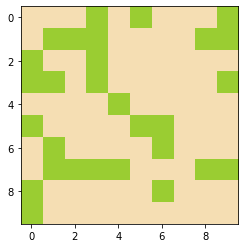

In [4]:
forest = Forest(10)
forest.random_init_trees()
plt.imshow(forest.cells, cmap=cmap)
#plt.imshow(forest.cells)

In [5]:
for i in range(50):
    start_loc = np.random.randint(forest.dimension, size = 2)
    A_f = forest.start_fire(start_loc)
    forest.plant_tree()

In [6]:
len(forest.grids)

224

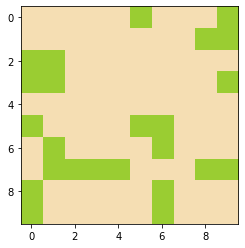

In [7]:
plt.imshow(forest.grids[12], cmap=cmap)

## Plotting

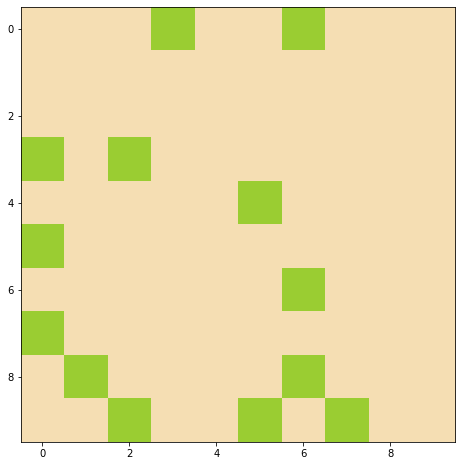

In [10]:
from PIL import Image
import matplotlib.animation as animation

#def animate_func(i):
    # animation function which is called sequentially
    #im.set_array(grids[i])
    #ax.set_title('Time step ' + str(i))
    #return im 

fps = 2
#nsec = 5

# set up the figure
fig, ax = plt.subplots(figsize=(8, 8))

# element to animate
#im = plt.imshow(grids[0])

frames=[]
for i in range(len(forest.grids)):
    #frames.append([plt.imshow(forest.grids[i])])
    frames.append([plt.imshow(forest.grids[i], cmap=cmap)])
    
anim = animation.ArtistAnimation(fig, frames, interval=1000, repeat=False, blit=True)
#anim = animation.FuncAnimation(fig, animate_func)
anim.save('test_anim.mp4', fps=fps)
